In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading the Dataset

In [2]:
import urllib.request
import zipfile

# URL to the Dataset
download_training_url = "https://storage.googleapis.com/learning-datasets/horse-or-human.zip"

# Filename once loaded into my workspace
filename = "horse-or-human-training.zip"

# Downloading the File
urllib.request.urlretrieve(download_training_url, filename)

# Training Directory in my Workspace
train_dir = "horse-or-human-dataset/training"

# Extracting the Zipfile
zip_ref_train = zipfile.ZipFile(filename, "r")
zip_ref_train.extractall(train_dir)
zip_ref_train.close()

In [3]:
# Validation URL
download_validation_url = "https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip"

# Local Alias for the ZipFile
filename = "horse-or-human-validation.zip"

# Downloading the File
urllib.request.urlretrieve(download_validation_url, filename)

# Validation Directory
valid_dir = "horse-or-human-dataset/validation"

# Extracting all the files
zip_ref_valid = zipfile.ZipFile(filename, "r")
zip_ref_valid.extractall(valid_dir)
zip_ref_valid.close()

In [4]:
import os

train_horse = os.path.join("/kaggle/working/horse-or-human-dataset", "training/horses/")
train_humans = os.path.join("/kaggle/working/horse-or-human-dataset", "training/humans/")

valid_horses = os.path.join("/kaggle/working/horse-or-human-dataset", "validation/horses/")
valid_humans = os.path.join("/kaggle/working/horse-or-human-dataset", "validation/humans/")

print(os.path.exists(train_horse))

True


## Accessing the Images

In [5]:
import os

image_train_horse = os.listdir(train_horse)
print("Training images of horses:\n", image_train_horse[:5])

image_train_human = os.listdir(train_humans)
print("\nTraining images of humans:\n", image_train_human[:5])

image_valid_horse = os.listdir(valid_horses)
print("\nValidation images of horses:\n", image_valid_horse[:5])

image_valid_human = os.listdir(valid_humans)
print("\nValidation images of humans:\n", image_valid_human[:5])

Training images of horses:
 ['horse27-7.png', 'horse20-3.png', 'horse34-6.png', 'horse03-4.png', 'horse31-7.png']

Training images of humans:
 ['human07-25.png', 'human15-09.png', 'human10-28.png', 'human05-28.png', 'human13-06.png']

Validation images of horses:
 ['horse4-403.png', 'horse2-314.png', 'horse5-504.png', 'horse6-004.png', 'horse6-153.png']

Validation images of humans:
 ['valhuman03-04.png', 'valhuman01-03.png', 'valhuman01-10.png', 'valhuman05-09.png', 'valhuman02-24.png']


## Autolabelling the Images

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_gen = data_gen.flow_from_directory(
    train_dir, target_size=(150, 150), class_mode="binary", batch_size=20
)

Found 1027 images belonging to 2 classes.


In [7]:
# Normalising the Test Examples for Consistency
test_gen = ImageDataGenerator(
    rescale=1/255
)

valid_gen = test_gen.flow_from_directory(
    valid_dir, target_size=(150, 150), class_mode="binary", batch_size=20
)

Found 256 images belonging to 2 classes.


## Applying Transfer Learning

In [8]:
# Utilising the Inception Computer Vision Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Loading the Pre-learnt Weights
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Local Alias for the File
weight_file = "InceptionWeights.h5"

# Downloading the Weights
urllib.request.urlretrieve(weights_url, weight_file)

('InceptionWeights.h5', <http.client.HTTPMessage at 0x7a19c7e5f100>)

In [9]:
# Loading the Model
inception_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)
inception_model.load_weights(weight_file)

## Viewing the Model

In [10]:
# inception_model.summary()

## Freezing the layers of the Model

In [11]:
for layer in inception_model.layers:
    layer.trainable = False    

In [12]:
# Declaring the Output Layer of ConvNet
last_layer = inception_model.get_layer("mixed7")
last_output = last_layer.output
print(f"Last Layer Output Shape: {last_layer.output_shape}")

Last Layer Output Shape: (None, 7, 7, 768)


## Adding Dense Layers to follow the ConvNet

In [13]:
# Flatten the output layer
flatten = tf.keras.layers.Flatten()(last_output)

# Add a fully connected layer
hidden1 = tf.keras.layers.Dense(1024, activation='relu')(flatten)
dropout1 = tf.keras.layers.Dropout(0.2)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.2)(hidden2)

# Add a final sigmoid layer for classification
output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout2)

## Creating the Model

In [14]:
new_model = tf.keras.Model(inputs=inception_model.input, outputs=output)
# new_model.summary()

## Compiling the Model

In [15]:
new_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

## Training the Model

In [16]:
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [17]:
history = new_model.fit(
    train_gen, validation_data=valid_gen, epochs=50, callbacks=[earlystop_cb]
)

Epoch 1/50
52/52 [==============================] - 19s 243ms/step - loss: 0.3004 - accuracy: 0.9289 - val_loss: 8.7861e-06 - val_accuracy: 1.0000
Epoch 2/50
52/52 [==============================] - 11s 207ms/step - loss: 0.1102 - accuracy: 0.9786 - val_loss: 3.6733e-05 - val_accuracy: 1.0000
Epoch 3/50
52/52 [==============================] - 11s 209ms/step - loss: 0.0686 - accuracy: 0.9883 - val_loss: 0.1220 - val_accuracy: 0.9805
Epoch 4/50
52/52 [==============================] - 11s 213ms/step - loss: 0.0992 - accuracy: 0.9834 - val_loss: 0.0699 - val_accuracy: 0.9844
Epoch 5/50
52/52 [==============================] - 11s 207ms/step - loss: 0.0535 - accuracy: 0.9893 - val_loss: 0.4871 - val_accuracy: 0.9531
Epoch 6/50
52/52 [==============================] - 11s 204ms/step - loss: 0.0840 - accuracy: 0.9883 - val_loss: 0.0487 - val_accuracy: 0.9922
Epoch 7/50
52/52 [==============================] - 11s 214ms/step - loss: 0.0579 - accuracy: 0.9932 - val_loss: 3.0544e-06 - val_accu

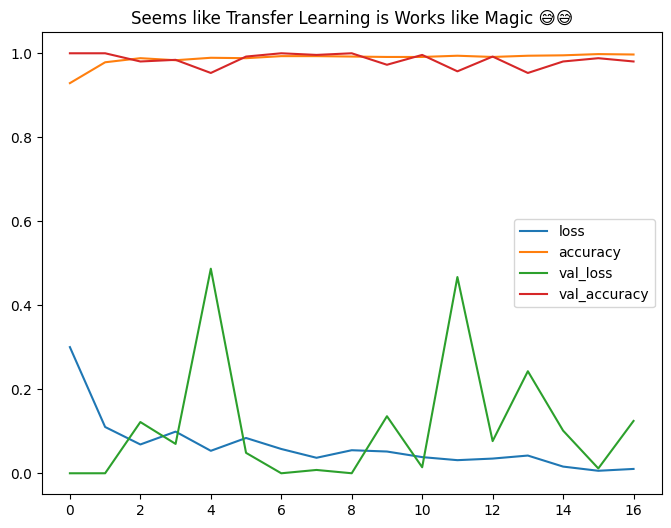

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.title("Seems like Transfer Learning is Works like Magic 😅😅")
plt.show()

## Testing the Model

**Predicting Horses**

1/1 [==============================] - 1s 1s/step
This is the image of a Horse
1/1 [==============================] - 0s 24ms/step
This is the image of a Horse
1/1 [==============================] - 0s 23ms/step
This is the image of a Horse
1/1 [==============================] - 0s 22ms/step
This is the image of a Horse


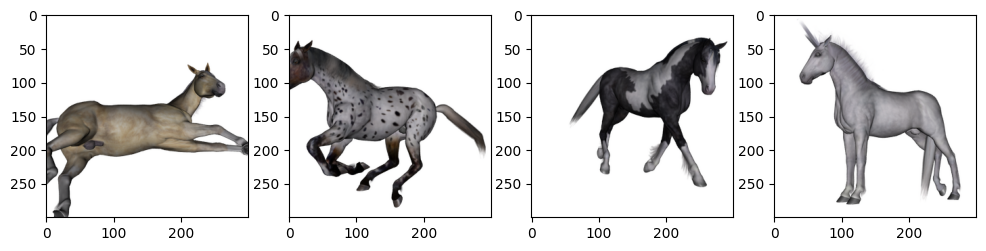

In [19]:
# Index for the Subplot
j = 1

# Plot Layout
plt.figure(figsize=(12, 15))

# Making Predictions and Displaying the Output
for i in image_valid_horse[:4]:
    
    # Locating the Image
    image_path = os.path.join(valid_horses, i)
    load_image = image.load_img(image_path, target_size=(150, 150))
    
    # Adjusting the Image
    x = image.img_to_array(load_image)
    x = np.expand_dims(x, axis=0)
    image_tensor = np.vstack([x])
    
    # Making the Prediction
    prediction = new_model.predict(image_tensor)
    
    if prediction > 0.5:
        print("This is the image of a Horse")
        
    else:
        print("This is the image of a Human")
       
    # Displaying the Image
    plt_image = mpimg.imread(image_path)    
    plt.subplot(1, 4, j)
    plt.imshow(plt_image)
    
    j += 1
    
plt.show()    

**Predicting Humans**

1/1 [==============================] - 0s 23ms/step
This is the image of a Human
1/1 [==============================] - 0s 23ms/step
This is the image of a Human
1/1 [==============================] - 0s 22ms/step
This is the image of a Human
1/1 [==============================] - 0s 22ms/step
This is the image of a Human


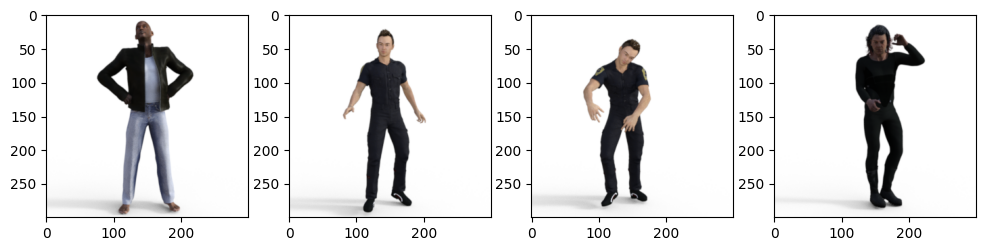

In [20]:
# Index for the Subplot
j = 1

# Plot Layout
plt.figure(figsize=(12, 15))

# Making Predictions and Displaying the Output
for i in image_valid_human[:4]:
    
    # Locating the Image
    image_path = os.path.join(valid_humans, i)
    load_image = image.load_img(image_path, target_size=(150, 150))
    
    # Adjusting the Image
    x = image.img_to_array(load_image)
    x = np.expand_dims(x, axis=0)
    image_tensor = np.vstack([x])
    
    # Making the Prediction
    prediction = new_model.predict(image_tensor)
    
    if prediction < 0.5:
        print("This is the image of a Horse")
        
    else:
        print("This is the image of a Human")
       
    # Displaying the Image
    plt_image = mpimg.imread(image_path)    
    plt.subplot(1, 4, j)
    plt.imshow(plt_image)
    
    j += 1
    
plt.show()